# Discharge Notes and Readmission Rates: NLP

This notebook is for the processing the cleaned dataset through a NLP.

## Import

Import the relevant libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#nlp libraries 
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
import string

#vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xg
from sklearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.utils import class_weight

In [104]:
def scores(model, X, y, set_type):
    '''
    This function takes in an already fitted model, X, y, and
    the type of data (train, validation, or test) in str format,
    and prints out the accuracy and recall scores. The function
    also prints out the confusion matrix
    '''
    pred = model.predict(X)
    
    print("{} Scores".format(set_type))
    print("accuracy: ", accuracy_score(y, pred))
    print("recall:   ", recall_score(y, pred))
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title(set_type)
    plot_confusion_matrix(model, X, y, ax=ax)
    return recall_score(y, pred)

In [3]:
stemmer = PorterStemmer()
def stem_text(text):
    '''
    This function takes a text and stem it
    '''
    return [stemmer.stem(w) for w in word_tokenize(text)]

In [4]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(token_text):
    '''
    This function takes an already tokenized text and lemmatize it
    '''
    return [lemmatizer.lemmatize(w) for w in token_text]

## Reading in the Data

Here, I read in the cleand dataset from the previous EDA folder.

In [5]:
df = pd.read_csv('data/admissions_cleaned_2.csv.gz', compression='gzip')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52726 entries, 0 to 52725
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      52726 non-null  object
 1   ADMISSION_LOCATION  52726 non-null  object
 2   DISCHARGE_LOCATION  52726 non-null  object
 3   INSURANCE           52726 non-null  object
 4   LANGUAGE            52726 non-null  object
 5   RELIGION            52726 non-null  object
 6   MARITAL_STATUS      52726 non-null  object
 7   ETHNICITY           52726 non-null  object
 8   DIAGNOSIS           52726 non-null  object
 9   READMISSION         52726 non-null  int64 
 10  GENDER              52726 non-null  object
 11  AGE                 52726 non-null  int64 
 12  TEXT                52726 non-null  object
 13  CPT_CD              52726 non-null  object
 14  DIAG_ICD9_CODE      52722 non-null  object
 15  DRG_CODE            52726 non-null  object
 16  PROCED_ICD9_CODE    52

In [7]:
df['READMISSION'].value_counts()

0    49715
1     3011
Name: READMISSION, dtype: int64

The dataset is heavily imbalanced, with a lot more negative cases. In order to handle class imbalance, I will later on use two method, SMOTE and undersampling, to mitigate the class imbalance.

## Preprocessing

In this section, I preprocessed the text data by removing punctuation and numbers, and lowercasing all the text. I decided to preprocess the text in this notebook rather than the first EDA notebook in case I decided to modify the text in a different way to help with my modeling.

In [8]:
#set X as the text data, and y as the readmission status
X = df['TEXT']
y = df['READMISSION']

In [9]:
#review the first text example to see how to preprocess the text data
X[0]

"Admission Date:  [**2100-6-7**]              Discharge Date:   [**2100-6-9**]\n\nDate of Birth:  [**2044-4-23**]             Sex:   M\n\nService: MEDICINE\n\nAllergies:\nNo Known Allergies / Adverse Drug Reactions\n\nAttending:[**First Name3 (LF) 2024**]\nChief Complaint:\ndizziness\n\nMajor Surgical or Invasive Procedure:\nNONE\n\n\nHistory of Present Illness:\nHistory of Present Illness: Mr. [**Known lastname 83415**] is a 56 year old male\nwith PMH notable for metastatic cancer (unknown primary)\nundergoing chemo now presenting with lighheadedness and\nhemoptysis. Pt is undergoing chemo with gemcitabine ([**2100-5-24**],\n[**2100-5-31**]) for malignant neoplasm of unknown primary with multiple\nbone, muscle, and soft-tissue metastases. He came to the\nhospital to start RT to L femur today.  Pt reports a couple days\nof lightheadedness, nonpositional.  Pt reports one episode of\nhemoptysis [**2100-6-3**] but none since then. No sig lung lesions on\nchest CT [**2100-5-27**]. Was sche

In [10]:
#remove line breaks and other formatting text
X = X.str.replace('\n',' ')
X = X.str.replace('\r',' ')

#remove punctuations and numbers
punc_list = string.punctuation
num_list = '0123456789'
punc_num_list = punc_list + num_list
pun_num_remove = str.maketrans(dict.fromkeys(punc_num_list, " "))
X = X.str.translate(pun_num_remove)

#lower case the text
X = X.str.lower()

In [11]:
#stem the words
X = X.apply(stem_text)

In [12]:
#stem the words
X = X.apply(lemmatize_text)

In [13]:
#join the words together
X = X.apply(' '.join)

## Train, Validation, and Test Split

I split the data set into three sets: Train, Validation, and Test.
The ratio I used was 70:15:15.

In [14]:
X_train, X_v_t, y_train, y_v_t = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [15]:
X_val, X_test, y_val, y_test = train_test_split(X_v_t, y_v_t, test_size=0.50, random_state=42, stratify=y_v_t)

In [16]:
X_train.shape

(36908,)

## Pipeline Parameters

In this section, I set specific pipeline parameters that I will keep constant throughout the project.

In [17]:
sw = stopwords.words('english')

#setting the number of maximum features as 10% of rows in X
max_feats = int(X_train.shape[0]*0.10)

## Modeling

In this section, I will run several different models. Once I decide the best model, I will export the results out so that in another notebook, I can merge that results to other data features and run that through models again to see if I can get a better model.

### Model 0: Dummy Classification

For my Model 0, I run a simple dummy classifier. I test out both a count vectorizer and a tfidf vectorizer to see if it will impact the results. I have yet to do anything about the class imbalance.

* Model: Dummy
* Vectorizer: Count
* Class Imbalance Solution: None

In [ ]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats)),
    ('dummy', DummyClassifier(strategy="stratified"))
    ])

In [ ]:
pp_count.fit(X_train, y_train)

scores(pp_count, X_train, y_train, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Dummy
* Vectorizer: Tfidf
* Class Imbalance Solution: None

In [ ]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('dummy', DummyClassifier(strategy="stratified")),   
    ])

In [ ]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

Though the accuracy is high for both the vectorizers through the dummy classifier model, the recall score was very poor. This is most likely due to the class imbalance. However, I will run a non-dummy, but simple logistic regression model to validate that the low recall score is not because of the dummy model itself.

### Model 1: Logistic Regression

The next model I decided to use is the logitic regression model.

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: None

In [ ]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

In [ ]:
pp_count.fit(X_train, y_train)

scores(pp_count, X_train, y_train, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: None

In [ ]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

In [ ]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

Again, the accuracy scores are high, but the recall scores are poor. Thus, for the next modeling step, I will try to improve the model by first trying to mitigate the class imbalance.

### Handling Imbalanced Data 

As mentioned before, the dataset is heavily imbalanced. I will implement three methods to handle the class imbalance:
* Undersample the negative cases
* Pass in class weights
* Implement SMOTE

#### Undersampling Negative Cases: 1 to 1

In [26]:
#concat the train dataset together
train_df = pd.concat([y_train, X_train], axis=1)

In [ ]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [ ]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=len(train_df_pos), random_state=42)

In [ ]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [ ]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [ ]:
#split out the X and y of the new dataset
y_train_1 = new_train_df['READMISSION']
X_train_1 = new_train_df['TEXT']
max_feats_1 = int(X_train_1.shape[0]*0.10)

#### Undersampling Negative Cases: 2 to 1

In [ ]:
#concat the train dataset together
train_df = pd.concat([y_train, X_train], axis=1)

In [ ]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [ ]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=2*len(train_df_pos), random_state=42)

In [ ]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [ ]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [ ]:
#split out the X and y of the new dataset
y_train_2 = new_train_df['READMISSION']
X_train_2 = new_train_df['TEXT']
max_feats_2 = int(X_train_2.shape[0]*0.10)

#### Undersampling Negative Cases: 3 to 1

In [ ]:
#concat the train dataset together
train_df = pd.concat([y_train, X_train], axis=1)

In [ ]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [ ]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=2*len(train_df_pos), random_state=42)

In [ ]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [ ]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [ ]:
#split out the X and y of the new dataset
y_train_3 = new_train_df['READMISSION']
X_train_3 = new_train_df['TEXT']
max_feats_3 = int(X_train_3.shape[0]*0.10)

#### Class Weights

In [ ]:
#calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=[0,1],y=y_train)

In [ ]:
class_weights

array([0.53028736, 8.75426945])

### Model 1.1: Logistic Regression - Undersampling

In this section, I applied the undersampled dataset to logistic regression model.

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: Undersampling Negative 1:1

In [ ]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7158444022770398
recall:    0.6883301707779886
Validation Scores
accuracy:  0.658743203944873
recall:    0.581858407079646
Test Scores
accuracy:  0.667720318624352
recall:    0.5942350332594235


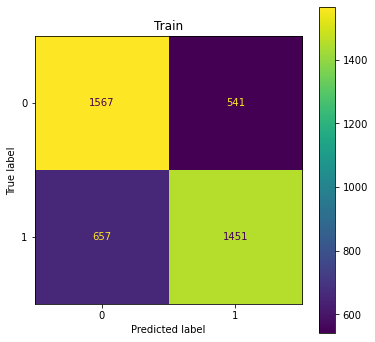

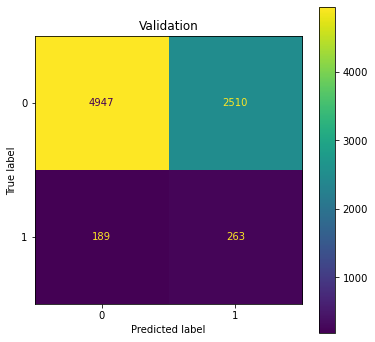

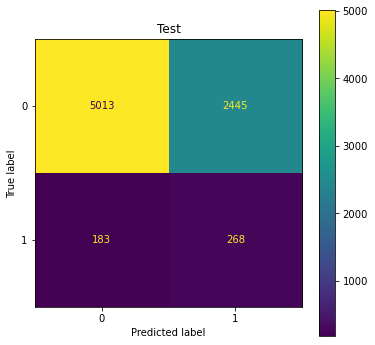

In [ ]:
pp_count.fit(X_train_1, y_train_1)

scores(pp_count, X_train_1, y_train_1, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Undersampling Negative 1:1

In [ ]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.6999525616698292
recall:    0.7016129032258065
Validation Scores
accuracy:  0.6511569098495384
recall:    0.6460176991150443
Test Scores
accuracy:  0.658743203944873
recall:    0.6430155210643016


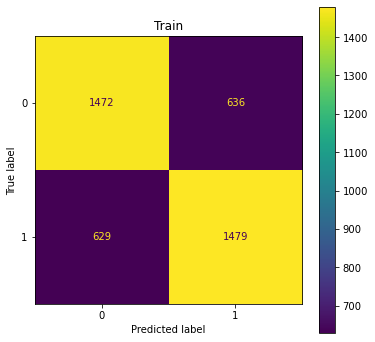

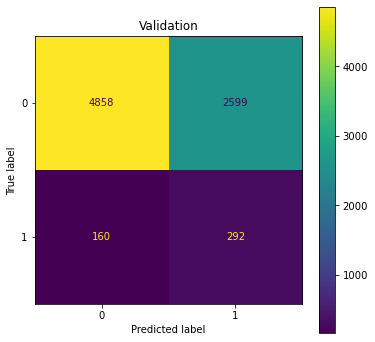

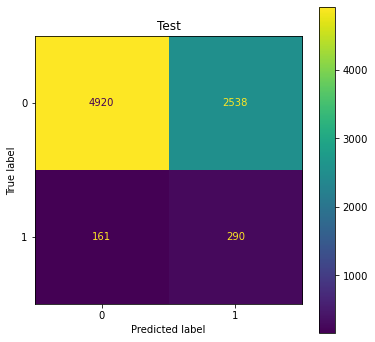

In [ ]:
pp_tfidf.fit(X_train_1, y_train_1)

scores(pp_tfidf, X_train_1, y_train_1, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: Undersampling Negative 2:1

In [ ]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats_2)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7647058823529411
recall:    0.5090132827324478
Validation Scores
accuracy:  0.7971930711847263
recall:    0.39601769911504425
Test Scores
accuracy:  0.8045264888102162
recall:    0.4146341463414634


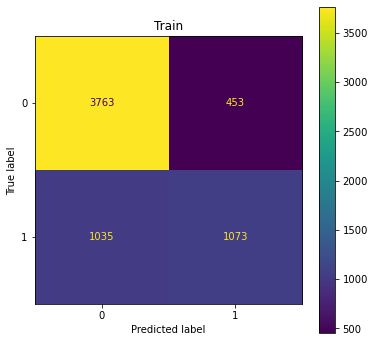

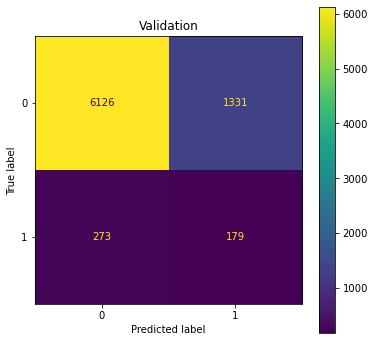

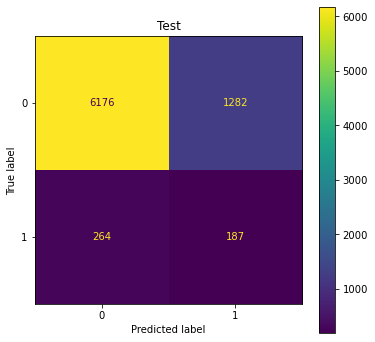

In [ ]:
pp_count.fit(X_train_2, y_train_2)

scores(pp_count, X_train_2, y_train_2, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Undersampling Negative 2:1

In [ ]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_2)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.7378241619228336
recall:    0.4060721062618596
Validation Scores
accuracy:  0.8444809710456442
recall:    0.3274336283185841
Test Scores
accuracy:  0.847009735744089
recall:    0.35033259423503327


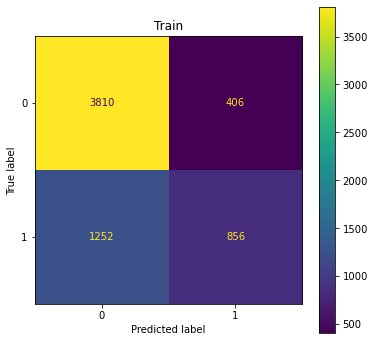

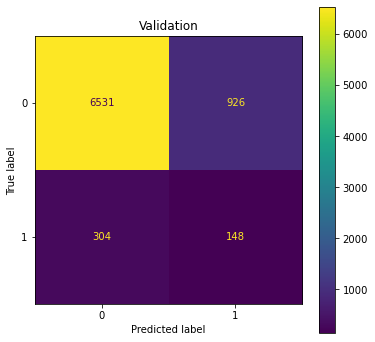

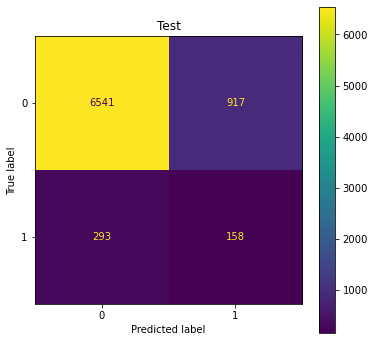

In [ ]:
pp_tfidf.fit(X_train_2, y_train_2)

scores(pp_tfidf, X_train_2, y_train_2, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: Undersampling Negative 3:1

In [ ]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats_3)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7647058823529411
recall:    0.5090132827324478
Validation Scores
accuracy:  0.7971930711847263
recall:    0.39601769911504425
Test Scores
accuracy:  0.8045264888102162
recall:    0.4146341463414634


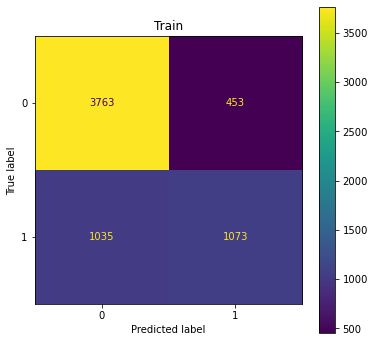

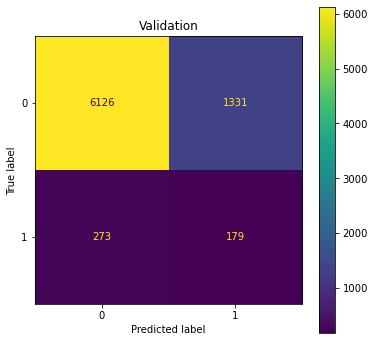

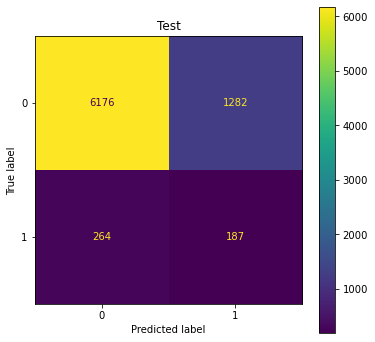

In [ ]:
pp_count.fit(X_train_3, y_train_3)

scores(pp_count, X_train_3, y_train_3, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Undersampling Negative 3:1

In [ ]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_3)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.7378241619228336
recall:    0.4060721062618596
Validation Scores
accuracy:  0.8444809710456442
recall:    0.3274336283185841
Test Scores
accuracy:  0.847009735744089
recall:    0.35033259423503327


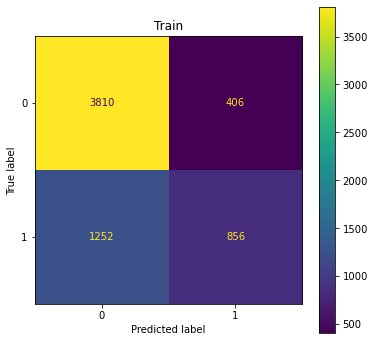

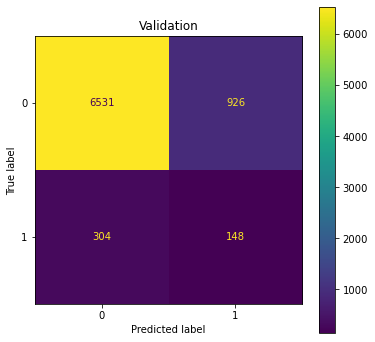

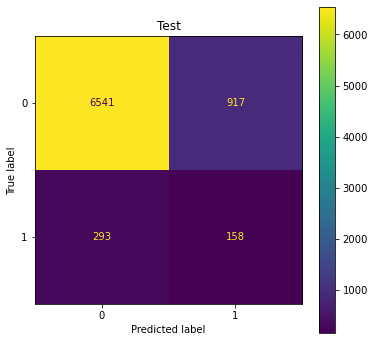

In [ ]:
pp_tfidf.fit(X_train_3, y_train_3)

scores(pp_tfidf, X_train_3, y_train_3, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

After using the undersampled dataset, though the accuracy went down, the recall score went up. The ratio of 1 to 1 of negative to positive cases had the best recall scores. In addition, the tfidf vectorizer performed better than the count vectorizer, and so we will just use the tfidf vectorizer.

### Model 1.2: Logistic Regression - Class Weights

In this section, I passed in the class weights in the logistic regression model.

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Class Weights

In [ ]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('logreg', LogisticRegression(random_state=42, class_weight=class_weights)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:680: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.9432372385390702
recall:    0.006641366223908918
Validation Scores
accuracy:  0.9433556707548363
recall:    0.008849557522123894
Test Scores
accuracy:  0.943229232519914
recall:    0.004434589800443459


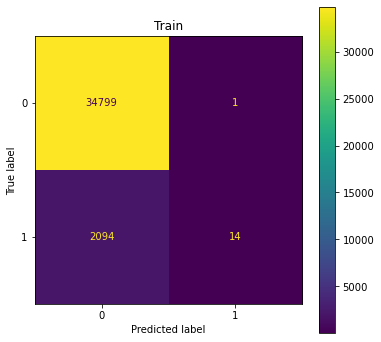

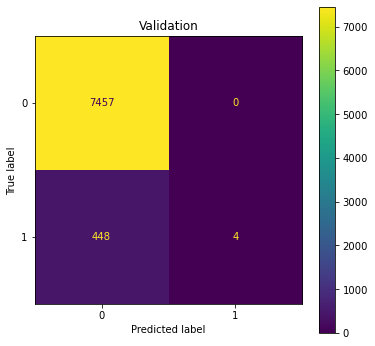

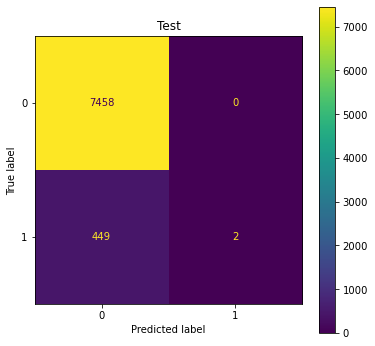

In [ ]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

As seen above, passing in the class weights did not improve the recall score.

### Model 1.3: Logistic Regression - SMOTE

In this section, I utilized SMOTE to oversample the imbalanced class.

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: SMOTE

In [ ]:
pp_tfidf = imbpipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(random_state=42))   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.8137260214587624
recall:    0.7751423149905123
Validation Scores
accuracy:  0.7803767859400683
recall:    0.497787610619469
Test Scores
accuracy:  0.7806296624099127
recall:    0.4811529933481153


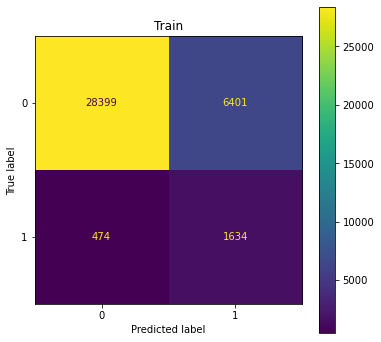

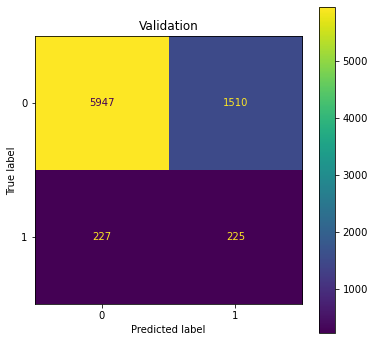

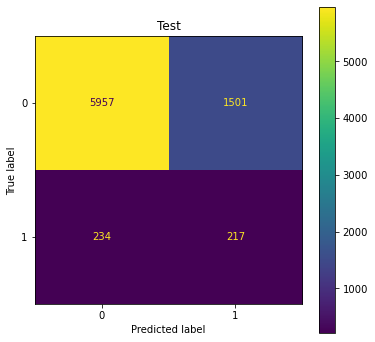

In [ ]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

SMOTE did improve the recall score. However, running SMOTE into grid search will take too much computation power. In addition, it led to the model overfitting. Therefore, I will not utilize SMOTE.

### Introducing N-Grams

I wanted to test if introducing n-grams into the data to see if it improves the score.

In [ ]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1, ngram_range=(1,3))),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.6883301707779886
recall:    0.6997153700189753
Validation Scores
accuracy:  0.6425591098748261
recall:    0.6526548672566371
Test Scores
accuracy:  0.6535592363130611
recall:    0.6518847006651884


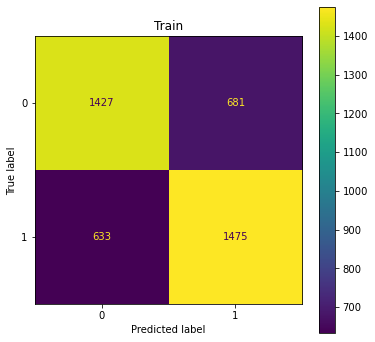

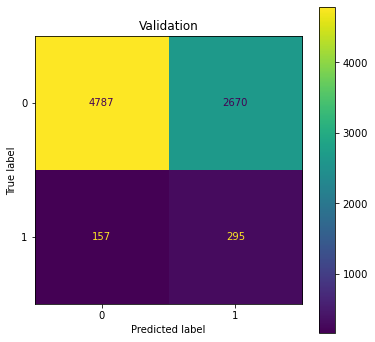

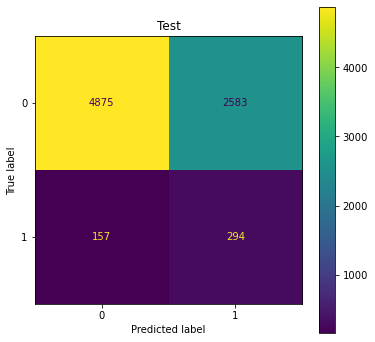

In [ ]:
pp_tfidf.fit(X_train_1, y_train_1)

scores(pp_tfidf, X_train_1, y_train_1, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

### Model X: Multinomial Naives Bayes

In [92]:
mnb = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('mnb', MultinomialNB())   
    ])

Train Scores
accuracy:  0.6435009487666035
recall:    0.6759962049335864
Validation Scores
accuracy:  0.6032368188140094
recall:    0.6438053097345132
Test Scores
accuracy:  0.6075357188013656
recall:    0.6718403547671841


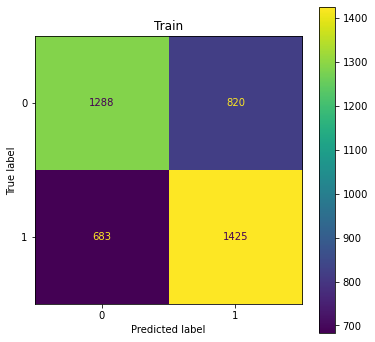

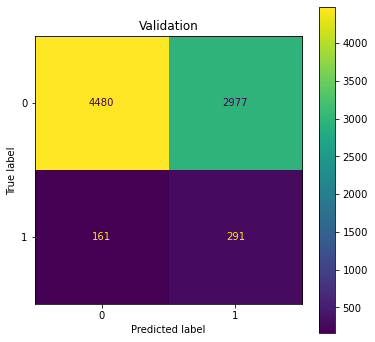

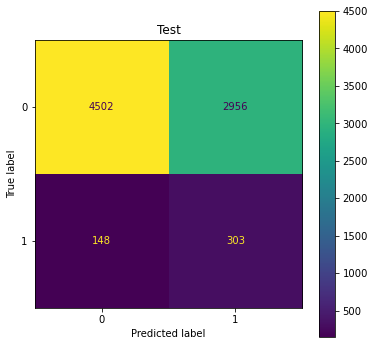

In [93]:
mnb.fit(X_train_1, y_train_1)

scores(mnb, X_train_1, y_train_1, 'Train')
scores(mnb, X_val, y_val, 'Validation')
scores(mnb, X_test, y_test, 'Test')

### Model X: Random Forest

In [99]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('rf', RandomForestClassifier(random_state=42))   
    ])

In [100]:
grid = {'rf__max_depth': [8,10],
        'rf__max_features': ['auto', 'sqrt'],
        'rf__min_samples_leaf': [1, 2, 4],
        'rf__min_samples_split': [2, 5, 7]}

In [101]:
gs_rf = GridSearchCV(estimator=pp_tfidf, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Train Scores
accuracy:  0.888045540796964
recall:    0.889943074003795
Validation Scores
accuracy:  0.6505247186749273
recall:    0.6460176991150443
Test Scores
accuracy:  0.648248830446327
recall:    0.656319290465632


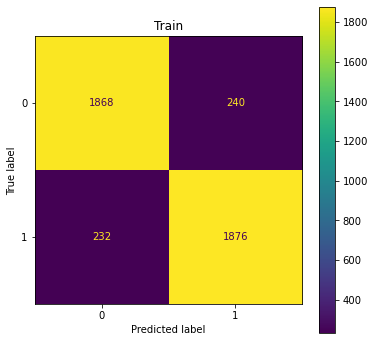

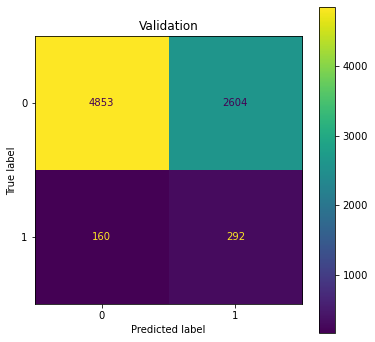

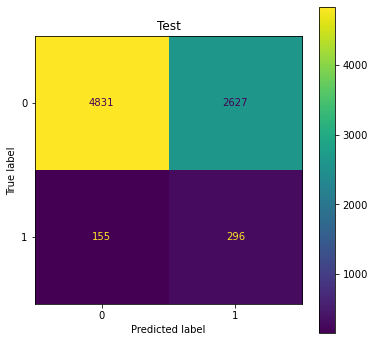

In [102]:
gs_rf.fit(X_train_1, y_train_1)

scores(gs_rf, X_train_1, y_train_1, 'Train')
scores(gs_rf, X_val, y_val, 'Validation')
scores(gs_rf, X_test, y_test, 'Test')

In [103]:
gs_rf.best_params_

{'rf__max_depth': 8,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 5}

In [ ]:
"""
{'rf__max_depth': 8,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 5}
"""

"\n{'rf__max_depth': 10,\n 'rf__max_features': 'auto',\n 'rf__min_samples_leaf': 1,\n 'rf__min_samples_split': 2}\n"

### Model X: K-Nearest Neighbors

In [ ]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('knn', KNeighborsClassifier())   
    ])

In [ ]:
grid = {'knn__n_neighbors': list(range(3, 10, 2)),
        'knn__weights': ['uniform', 'distance']}

In [ ]:
gs_knn = GridSearchCV(estimator=pp_tfidf, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Train Scores
accuracy:  0.7001897533206831
recall:    0.8012333965844403
Validation Scores
accuracy:  0.5200404602351751
recall:    0.7278761061946902
Test Scores
accuracy:  0.5369831837147554
recall:    0.7405764966740577


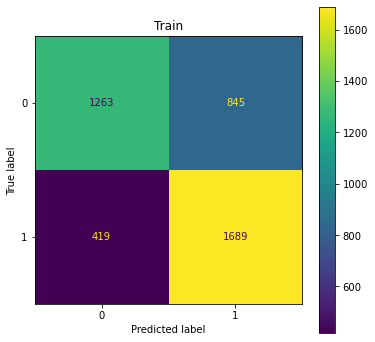

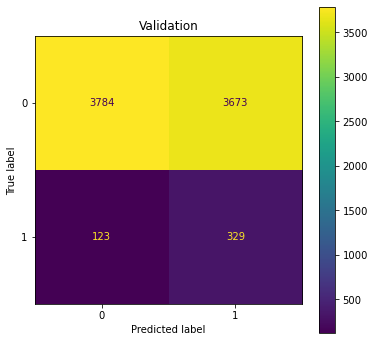

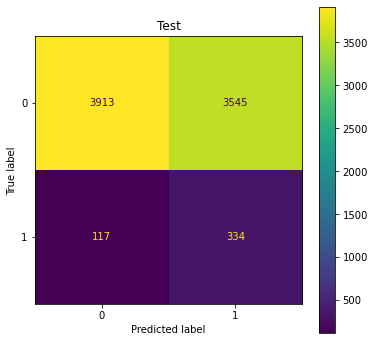

In [ ]:
gs_knn.fit(X_train_1, y_train_1)

scores(gs_knn, X_train_1, y_train_1, 'Train')
scores(gs_knn, X_val, y_val, 'Validation')
scores(gs_knn, X_test, y_test, 'Test')

In [ ]:
gs_knn.best_params_

{'knn__n_neighbors': 9, 'knn__weights': 'uniform'}

In [ ]:
"""
{'knn__n_neighbors': 9, 'knn__weights': 'uniform'}
"""

"\n{'knn__n_neighbors': 9, 'knn__weights': 'uniform'}\n"

### Model X: Decision Tree Model

In [ ]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('dt', DecisionTreeClassifier(random_state=42))   
    ])

In [ ]:
grid = {'dt__criterion': ['gini', 'entropy'],
        'dt__max_depth': np.arange(1,16, 5),
        'dt__min_samples_split': np.arange(40, 101, 20),
        'dt__min_samples_leaf': np.arange(40, 101,20)
       }

In [ ]:
gs_dt = GridSearchCV(estimator=pp_tfidf, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Train Scores
accuracy:  0.6904648956356736
recall:    0.676944971537002
Validation Scores
accuracy:  0.5969149070678973
recall:    0.6150442477876106
Test Scores
accuracy:  0.5985586041218864
recall:    0.5764966740576497


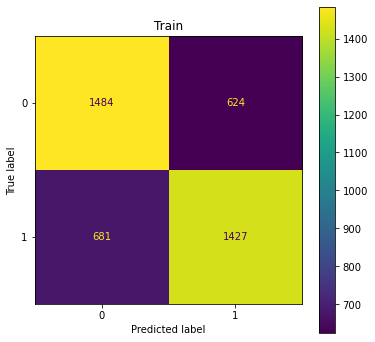

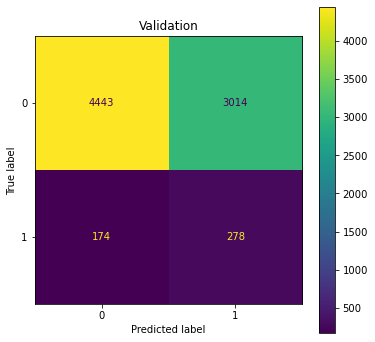

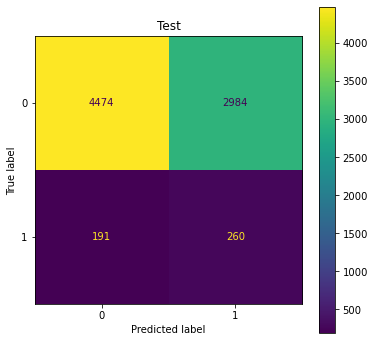

In [ ]:
gs_dt.fit(X_train_1, y_train_1)

scores(gs_dt, X_train_1, y_train_1, 'Train')
scores(gs_dt, X_val, y_val, 'Validation')
dt_recall = scores(gs_dt, X_test, y_test, 'Test')

In [ ]:
gs_dt.best_params_

{'dt__criterion': 'gini',
 'dt__max_depth': 6,
 'dt__min_samples_leaf': 40,
 'dt__min_samples_split': 40}

In [ ]:
"""
{'dt__criterion': 'entropy',
 'dt__max_depth': 6,
 'dt__min_samples_leaf': 40,
 'dt__min_samples_split': 100
"""

"\n{'dt__criterion': 'entropy',\n 'dt__max_depth': 6,\n 'dt__min_samples_leaf': 40,\n 'dt__min_samples_split': 100\n"

### Model X: Gradient Boost

In [ ]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('gbc', GradientBoostingClassifier(random_state=42))   
    ])

In [ ]:
grid = {'gbc__max_features': ['auto','log2'],
        'gbc__min_samples_split':[10, 50, 100, 1000],
        'gbc__max_depth':[3, 5, 10, 20]
       }

In [ ]:
gs_gbc = GridSearchCV(estimator=pp_tfidf, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Train Scores
accuracy:  0.7554554079696395
recall:    0.7618595825426945
Validation Scores
accuracy:  0.6406625363509926
recall:    0.6592920353982301
Test Scores
accuracy:  0.6462258186875711
recall:    0.6829268292682927


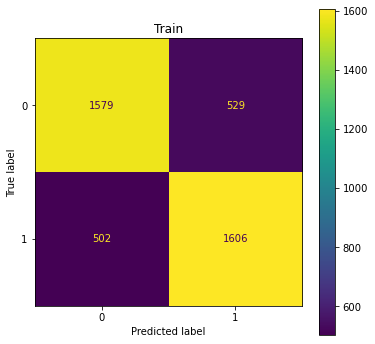

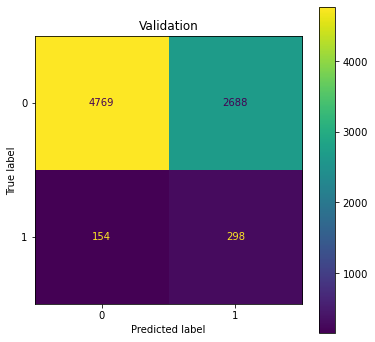

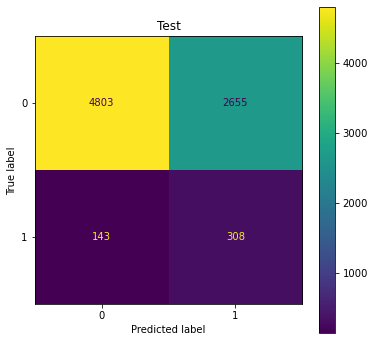

In [ ]:
gs_gbc.fit(X_train_1, y_train_1)

scores(gs_gbc, X_train_1, y_train_1, 'Train')
scores(gs_gbc, X_val, y_val, 'Validation')
gbc_recall = scores(gs_gbc, X_test, y_test, 'Test')

In [ ]:
gs_gbc.best_params_

{'gbc__max_depth': 3,
 'gbc__max_features': 'auto',
 'gbc__min_samples_split': 1000}

In [91]:
gs_gbc.best_params_

{'gbc__max_depth': 3,
 'gbc__max_features': 'auto',
 'gbc__min_samples_split': 1000}

In [ ]:
"""
{'gbc__max_depth': 3,
 'gbc__max_features': 'auto',
 'gbc__min_samples_split': 1000
"""

"\n{'gbc__max_depth': 10,\n 'gbc__max_features': 'log2',\n 'gbc__min_samples_split': 50}\n"

### Model X: Ensemble

In [109]:
mnb = MultinomialNB()

rf = RandomForestClassifier(random_state=42,
                            max_depth= 8,
                            max_features= 'auto',
                            min_samples_leaf= 2,
                            min_samples_split= 5)

knn = KNeighborsClassifier(n_neighbors= 9,
                           weights= 'uniform')

dt = DecisionTreeClassifier(random_state=42,
                            criterion= 'gini',
                            max_depth= 6,
                            min_samples_leaf= 40,
                            min_samples_split= 40)

gb = GradientBoostingClassifier(random_state=42,
                               max_depth= 3,
                                max_features= 'auto',
                                min_samples_split= 1000)

In [110]:
voting_clf = VotingClassifier(estimators={
                                          ("mnb", mnb),
                                          ("rf", rf),
                                          ('knn', knn),
                                          ('dt', dt),
                                          ("gb", gb)
                                         }, 
                                          voting= "soft")

In [113]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('rf', VotingClassifier(estimators={
                                          ("mnb", mnb),
                                          ("rf", rf),
                                          ('knn', knn),
                                          ('dt', dt),
                                          ("gb", gb)
                                         }, 
                                          voting= "soft"))   
    ])

Train Scores
accuracy:  0.7765654648956357
recall:    0.8069259962049335
Validation Scores
accuracy:  0.6133518776077886
recall:    0.7101769911504425
Test Scores
accuracy:  0.6200531040586673
recall:    0.7117516629711752


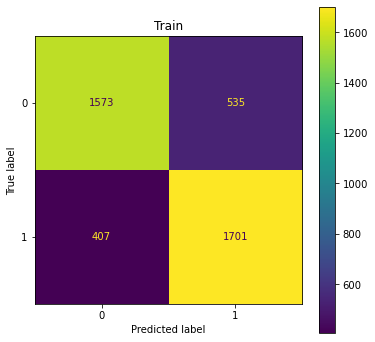

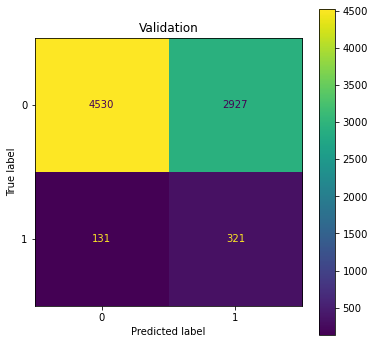

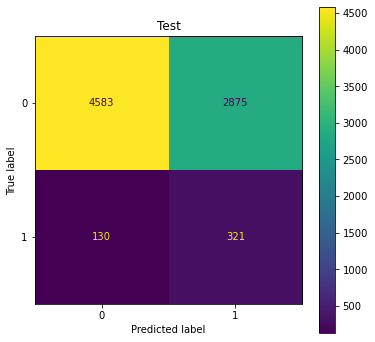

In [ ]:
pp_tfidf.fit(X_train_1, y_train_1)

scores(pp_tfidf, X_train_1, y_train_1, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
ensem_recall = scores(pp_tfidf, X_test, y_test, 'Test')